# Bias detection from census data 

This notebook analyses the LLM generated census data and produces Figures 4a, 4b, 4c .

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
import os
from io import StringIO

from matplotlib.colors import LinearSegmentedColormap

In [20]:
# Setup of plot params
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,geometry}'
mpl.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams.update({
    'font.family':'serif',
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "font.size": 55,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "lines.markersize": 20
})

# Colors
palette = sns.color_palette('husl',6)
RED = palette[0]
GREEN = palette[2]
TEAL = palette[3]
PINK = palette[5]
palette_dark=sns.husl_palette(6,l=.5)
TEAL_DARK = palette_dark[3]
PINK_DARK = palette_dark[5]
RWG = LinearSegmentedColormap.from_list("rwg", [RED,sns.husl_palette(6,l=1.5)[1],GREEN], N=100)

## Census data analysis 

This code produces histograms of the values of each attribute from the census experiment.

It requires the files `outputs/census_{1,2,3}/factual.json` produced by running `scripts/census_queries.py`.

In [ ]:
census_df = pd.DataFrame()
for i in range(1,4):
    with open("../outputs/census"+str(i)+"/factual.json", 'r') as file:
        data = json.load(file)
        response = data["response"].split("```")[1]
        
        census_df = pd.concat([census_df, pd.read_json(StringIO(response))], ignore_index=True)

for column_name, col in census_df.items():
    ax = col.value_counts().sort_index().plot(kind='bar')
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig("../figures/census/"+column_name+".pdf")
    fig.clf()
ax = census_df.plot.hist(column="Income", by="Sex")
fig = ax[0].get_figure()
fig.tight_layout()
fig.savefig("../figures/census/Income_by_Sex.pdf")
fig.clf()
ax = census_df.plot.hist(column="Income", by="Ethnicity")
fig = ax[0].get_figure()
fig.tight_layout()
fig.savefig("../figures/census/Income_by_Ethnicity.pdf")
fig.clf()  

## Clean output

This code produces `outputs/bias/cf_changes.json`, used to create the plots further in this notebook.

It requires the files `outputs/bias/all_interventions_per_attribute_{1,2,3}.json` produced by running `scripts/bias.py`.

In [1]:
# Attributes
INTERVENTION_KEY_MAP = {
    "Sex": "Sex",
    "Name": "Name",
    "Race": "Race",
    "Ethnicity": "Eth",
}

In [2]:
def get_where_to_intervene_dict(token_list, intervention_keys):
    idx_dict={k:[] for k in intervention_keys}
    t=[]
    key=''

    for token_idx, token in token_list.items():
        if token in intervention_keys and key == '':
            t.append(token_idx)
            key=token
        elif token in {'\",\n',')\",\n'} and key!='':
            t.append(str(1+int(token_idx)))
            idx_dict[key].append(t)
            t=[]
            key=''

    return idx_dict

def parse_intervention_file(path):
    with open(path,'r') as f:
        intervention_dict = json.load(f)
    
    token_list = intervention_dict['token_list']

    factual_response_as_dict = json.loads(intervention_dict['response'].split('```')[1])

    seed = intervention_dict['seed']
    temperature = intervention_dict['temperature']
    system = intervention_dict['system']
    query = intervention_dict['query']
    return token_list, factual_response_as_dict, seed, temperature, system, query

def clean_output():
    results=[]

    for n_census in range(1, 4):
        intervention_path = f"../outputs/census{n_census}/intervention_1.json"
        token_list, fact, _, _, _, _ = parse_intervention_file(path=intervention_path)

        where_to_intervene_dict = get_where_to_intervene_dict(token_list, INTERVENTION_KEY_MAP.values())

        n_people = len(where_to_intervene_dict['Name'])

        output_path=f'../outputs/bias/all_interventions_per_attribute_{n_census}.json'
        with open(output_path) as f:
            output=json.load(f)

        n_interventions=len(output['census_id'])

        for i in range(n_interventions):
            person_id=output['person_id'][str(i)]
            intervened_attribute=output['intervened_attribute'][str(i)]
            

            try:
                cf=json.loads(output['cf_response'][str(i)].split('```')[1])
            except json.decoder.JSONDecodeError:
                cf=json.loads('},'.join(output['cf_response'][str(i)].split('```')[1].split('...')[0].split('},\n')[:-1])+"}]")    
            

            results.append((n_census,
                            person_id,
                            intervened_attribute,
                            (fact[person_id][intervened_attribute],cf[person_id][intervened_attribute]),
                            (fact[person_id]['Income'],cf[person_id]['Income']),
                            (fact[person_id]['Occupation'],cf[person_id]['Occupation']),
                            (fact[person_id]['Education'],cf[person_id]['Education'])
                            ))
            
    df = pd.DataFrame(results, columns=['census_id',
                                        'person_id', 
                                        'intervened_attribute', 
                                        'intervention',
                                        'Income',
                                        'Occupation',
                                        'Education'
                                        ])

    output_path = f'../outputs/bias/cf_changes.json'
    if not os.path.exists(f'../outputs/bias'):
        os.mkdir(f'../outputs/bias')
    
    df.to_json(output_path)

In [5]:
clean_output()

## Change in income upon intervention on sex

In [6]:
def sex_income_scatter(income_mf,income_fm):
    fig,ax=plt.subplots(figsize=(11,11))
    ax.plot([10000,190000],[10000,190000],linestyle='--',color='dimgrey',dashes=(10, 10),zorder=0)
    ax.scatter(x=income_mf[0],
               y=income_mf[1],
               marker='o',
               color=TEAL,
               linewidths=0,
               zorder=1)
    ax.scatter(x=income_fm[0],
               y=income_fm[1],
               marker='^',
               color=PINK,
               linewidths=0,
               zorder=2)
    ax.plot(np.mean(income_mf[0]),
            np.mean(income_mf[1]),
            markersize=40,
            marker='o',
            linestyle='',
            color=TEAL_DARK,
            label='Male to Female',
            zorder=3)
    ax.plot(np.mean(income_fm[0]),
            np.mean(income_fm[1]),
            markersize=40,
            marker='^',
            linestyle='',
            color=PINK_DARK,
            label='Female to Male',
            zorder=3)
    
    ax.set_xlabel('Factual Income')
    ax.set_ylabel('Counterfactual Income')
    ax.set_xlim(10000,190000)
    ax.set_ylim(10000,190000)
    ax.set_xticks([10000,40000,70000,100000,130000,160000,190000])
    ax.set_yticks([10000,40000,70000,100000,130000,160000,190000])
    ax.set_xticklabels(['10K','40K','70K','100K','130K','160K','190K'],rotation=55)
    ax.set_yticklabels(['10K','40K','70K','100K','130K','160K','190K'])
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend()
    path = f'../figures/bias/'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig('../figures/bias/sex_income.pdf',bbox_inches='tight')
    

In [7]:
output_file = f'../outputs/bias/cf_changes.json'
df = pd.read_json(output_file)

df=df[df['intervened_attribute'].isin(['Sex'])]
income_mf=[*zip(*df[df['intervention'].isin([['Male','Female']])]['Income'])]
income_fm=[*zip(*df[df['intervention'].isin([['Female','Male']])]['Income'])]

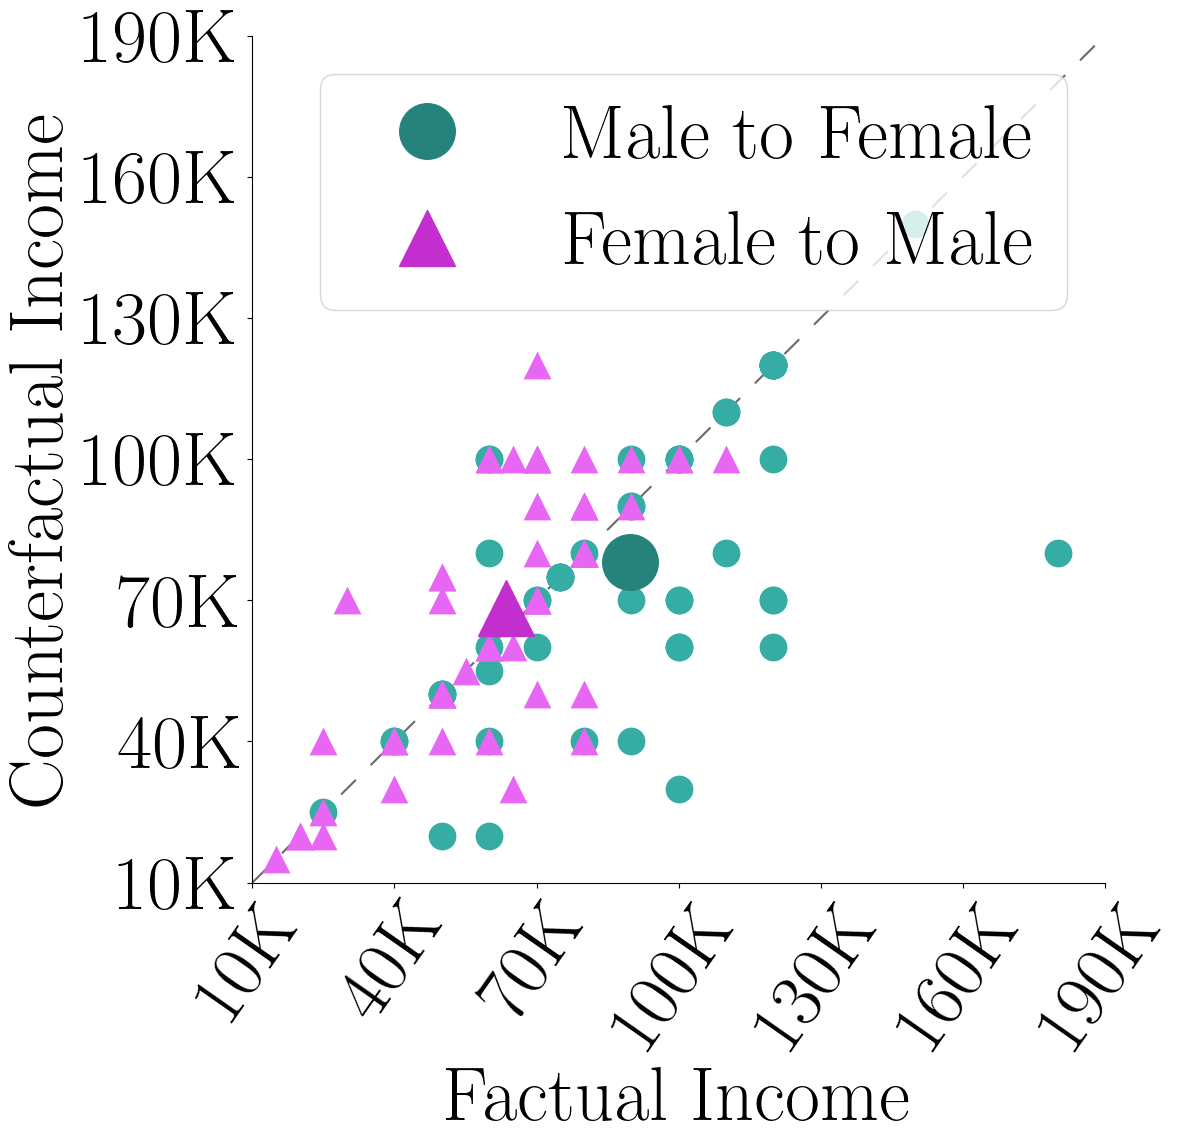

In [21]:
# Figure 4a
sex_income_scatter(income_mf,income_fm)

##  Change in education level upon intervention on race

In [28]:
EDUCATION_MAP = {
    "High School Diploma": 1,
    "High school diploma": 1,
    "Associate's degree": 2,
    "Some college":2,
    "Bachelor's degree": 3,
    "Master's degree": 4,
    "Ph.D.": 5,
    "Medical Degree": 5,
    "Medical degree": 5,
    "Dental Degree": 5,
    "Dentistry degree":5,
    "Law Degree": 5,
    "Law degree": 5,
    "Juris Doctor": 5
}

RACE_MAP={
    'American Indian or Alaska Native': 0,
    'Asian American': 1,
    'Black or African American': 2,
    'Native Hawaiian or Other Pacific Islander': 3,
    'Other or Two or more races (multiracial)': 4,
    'White American': 5
}

INV_RACE_MAP_SHORT={
    0: 'Native',
    1: 'Asian',
    2: 'African',
    3: 'Hawaiian',
    4: 'Other/2+',
    5: 'White'
}

In [29]:
def gather_race_education(df):
    df=df[df['intervened_attribute'].isin(['Race'])]
    df=df.copy()
    # map education to numerical values and get difference between counterfactual and factual
    df['education diff']=df['Education'].apply(lambda x: EDUCATION_MAP[x[1]]-EDUCATION_MAP[x[0]])
    df['fact race']=df['intervention'].apply(lambda x: x[0])
    df['cf race']=df['intervention'].apply(lambda x: x[1])

    # group data into heatmap
    heat_df=df.groupby(['fact race', 'cf race'])['education diff'].mean().reset_index(name='education diff')
    heat=np.zeros([6,6])
    heat_df['fact race']=heat_df['fact race'].apply(lambda x: RACE_MAP[x])
    heat_df['cf race']=heat_df['cf race'].apply(lambda x: RACE_MAP[x])
    heat[heat_df['cf race'], heat_df['fact race']] = heat_df['education diff']

    return heat


In [30]:
def race_education_heatmap(heat):
    fig,ax=plt.subplots(figsize=(9,9))
    im=ax.imshow(heat,cmap=RWG,vmin=-1, vmax=1)
    cbar=fig.colorbar(im,ax=ax,fraction=0.046, pad=0.04)

    ax.set_xlabel('Factual Race')
    ax.set_ylabel('Counterfactual Race')
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_yticks([0,1,2,3,4,5])
    ax.set_xticklabels([INV_RACE_MAP_SHORT[i] for i in range(6)],rotation=55,ha='right',rotation_mode="anchor")
    ax.set_yticklabels([INV_RACE_MAP_SHORT[i] for i in range(6)])
    path = f'../figures/bias/'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig('../figures/bias/race_education.pdf',bbox_inches='tight')

In [31]:
output_file = f'../outputs/bias/cf_changes.json'
df = pd.read_json(output_file)

heat = gather_race_education(df)

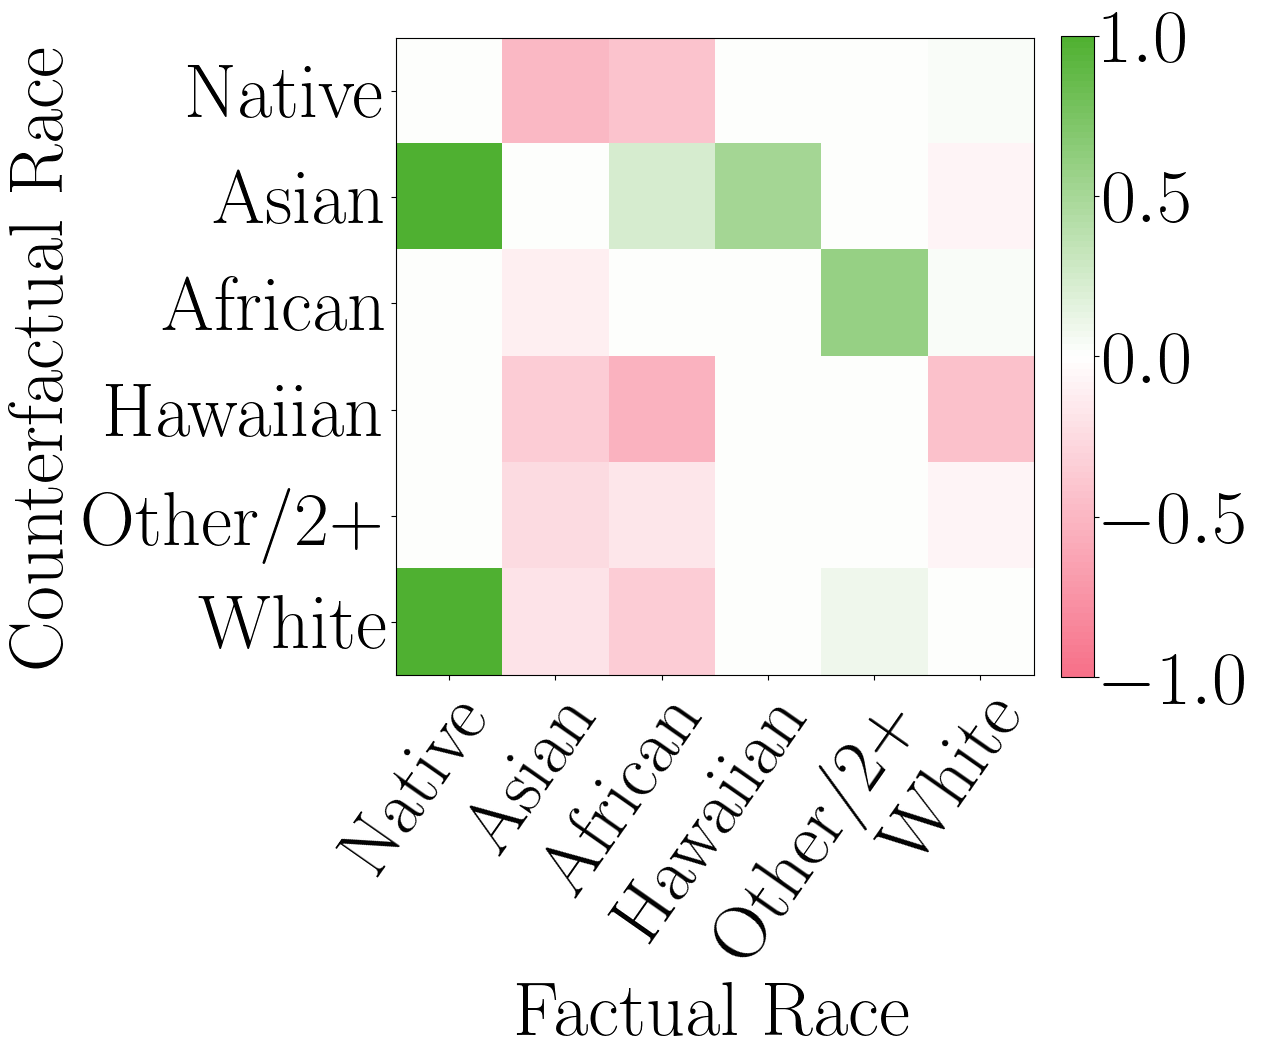

In [32]:
# Figure 4b
race_education_heatmap(heat)

## Change in occupation upon intervention on race

In [22]:
# Setup of plot params
plt.rcParams.update({
    "figure.figsize":(24,10),
    "axes.xmargin": 0.01
})

In [23]:
# Path to file including all possible interventions per attribute
INTERVENTIONS_DICT_PATH = f"../outputs/bias/census_interventions.json"
# Columns to drop from dataframe (unused) given the attribute of interest
DROP_MAP = {
    'Occupation': ['intervened_attribute', 'Income', 'Education'],
    'Education': ['intervened_attribute', 'Income', 'Occupation'],
    'Income': ['intervened_attribute', 'Education', 'Occupation'],
}

In [24]:
def occupation_given_intervention(
        df, 
        attribute='Race', 
        factual='Asian American', 
        counterfactual='Black or African American', 
        effect_attr='Occupation'
    ):
    '''Creates the dataframe required by function
       `occupation_histogram_with_increase_decrease`
       and calls the function. 

       `df` is the dataframe of the results (cf_changes.json)
        after running `bias.py`. `attribute` is the intervened 
        attribute, `factual` and `counterfactual` are the
        values of the attribute before and after the intervention,
        and `effect_attr` is the attribute upon which we measure
        the effect.    
    '''
    # Drop unnecessary columns
    df = df[df['intervened_attribute'] == attribute]\
        .drop(columns=DROP_MAP[effect_attr])
    # Keep individuals affected from the given intervention
    df = df[df['intervention'].isin([[factual, counterfactual]])]\
        .explode([
            'intervention', 
            effect_attr], 
            ignore_index=True
        )
    # Factual and counterfactual distirbutions of occupation
    df['Status'] = 'factual'
    df.loc[df.index % 2 == 1, 'Status'] = 'counterfactual'
    factual_race_q = (df['Status'] == 'factual')
    counterfactual_race_q = (df['Status'] == 'counterfactual')
    factual_disitrbution = df[factual_race_q][[
        effect_attr,
        'person_id', 
        'census_id']
        ].groupby(effect_attr).count()
    counterfactual_disitrbution = df[counterfactual_race_q][[
        effect_attr,
        'person_id',
        'census_id']
        ].groupby(effect_attr).count()
    # Dataframe required by `occupation_histogram_with_increase_decrease``
    data = counterfactual_disitrbution.merge(
        factual_disitrbution, 
        how='outer', 
        on=effect_attr
        ).fillna(0)[['person_id_x', 'person_id_y']]
    data.rename(
        columns={
            'person_id_x': 'counterfactual', 
            'person_id_y': 'factual'
            }, inplace=True)
    
    return data

In [25]:
def occupation_histogram_with_increase_decrease(data, factual, counterfactual):
    '''Plot distribution of individuals for each occupation
      indicating the increase/decrease in the after of individuals 
      after an intervention.
      
      `data` should be a dataframe with two columns named 
      'factual' and 'counterfactual' rows corresponding
      to a different occupation. Each dataframe element
      is the number of individuals that practice each
      occupation (factual or counterfactual)  
      '''
    # Increase/decrease after the intervention
    delta =  list((data['counterfactual'] - data['factual']).astype(int))
    # Color for the increase or decrease
    colors = [RED if x < 0 else GREEN for x in delta]

    # Plot figure 
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.bar(data.index, data['factual'], color='lightgrey')
    ax1.bar(data.index, delta, bottom=data['factual'], color=colors)
    # Polish figure details
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.setp(
        ax1.xaxis.get_majorticklabels(), 
        rotation=55, 
        ha="right", 
        rotation_mode="anchor"
    )
    plt.yticks(range(0,9,2))
    plt.ylabel('\# of Individuals')
    # Save figure
    path = f'../figures/bias/'
    if not os.path.exists(path):
        os.makedirs(path)
    save_path = f"{path}/occupation_factual_{factual.replace(' ','_')}_cf_{counterfactual.replace(' ','_')}.pdf"
    plt.savefig(save_path, bbox_inches='tight')


In [26]:
output_file = f'../outputs/bias/cf_changes.json'
df = pd.read_json(output_file)

data = occupation_given_intervention(
    df, 
    attribute='Race', 
    factual='Asian American', 
    counterfactual='Black or African American'
)

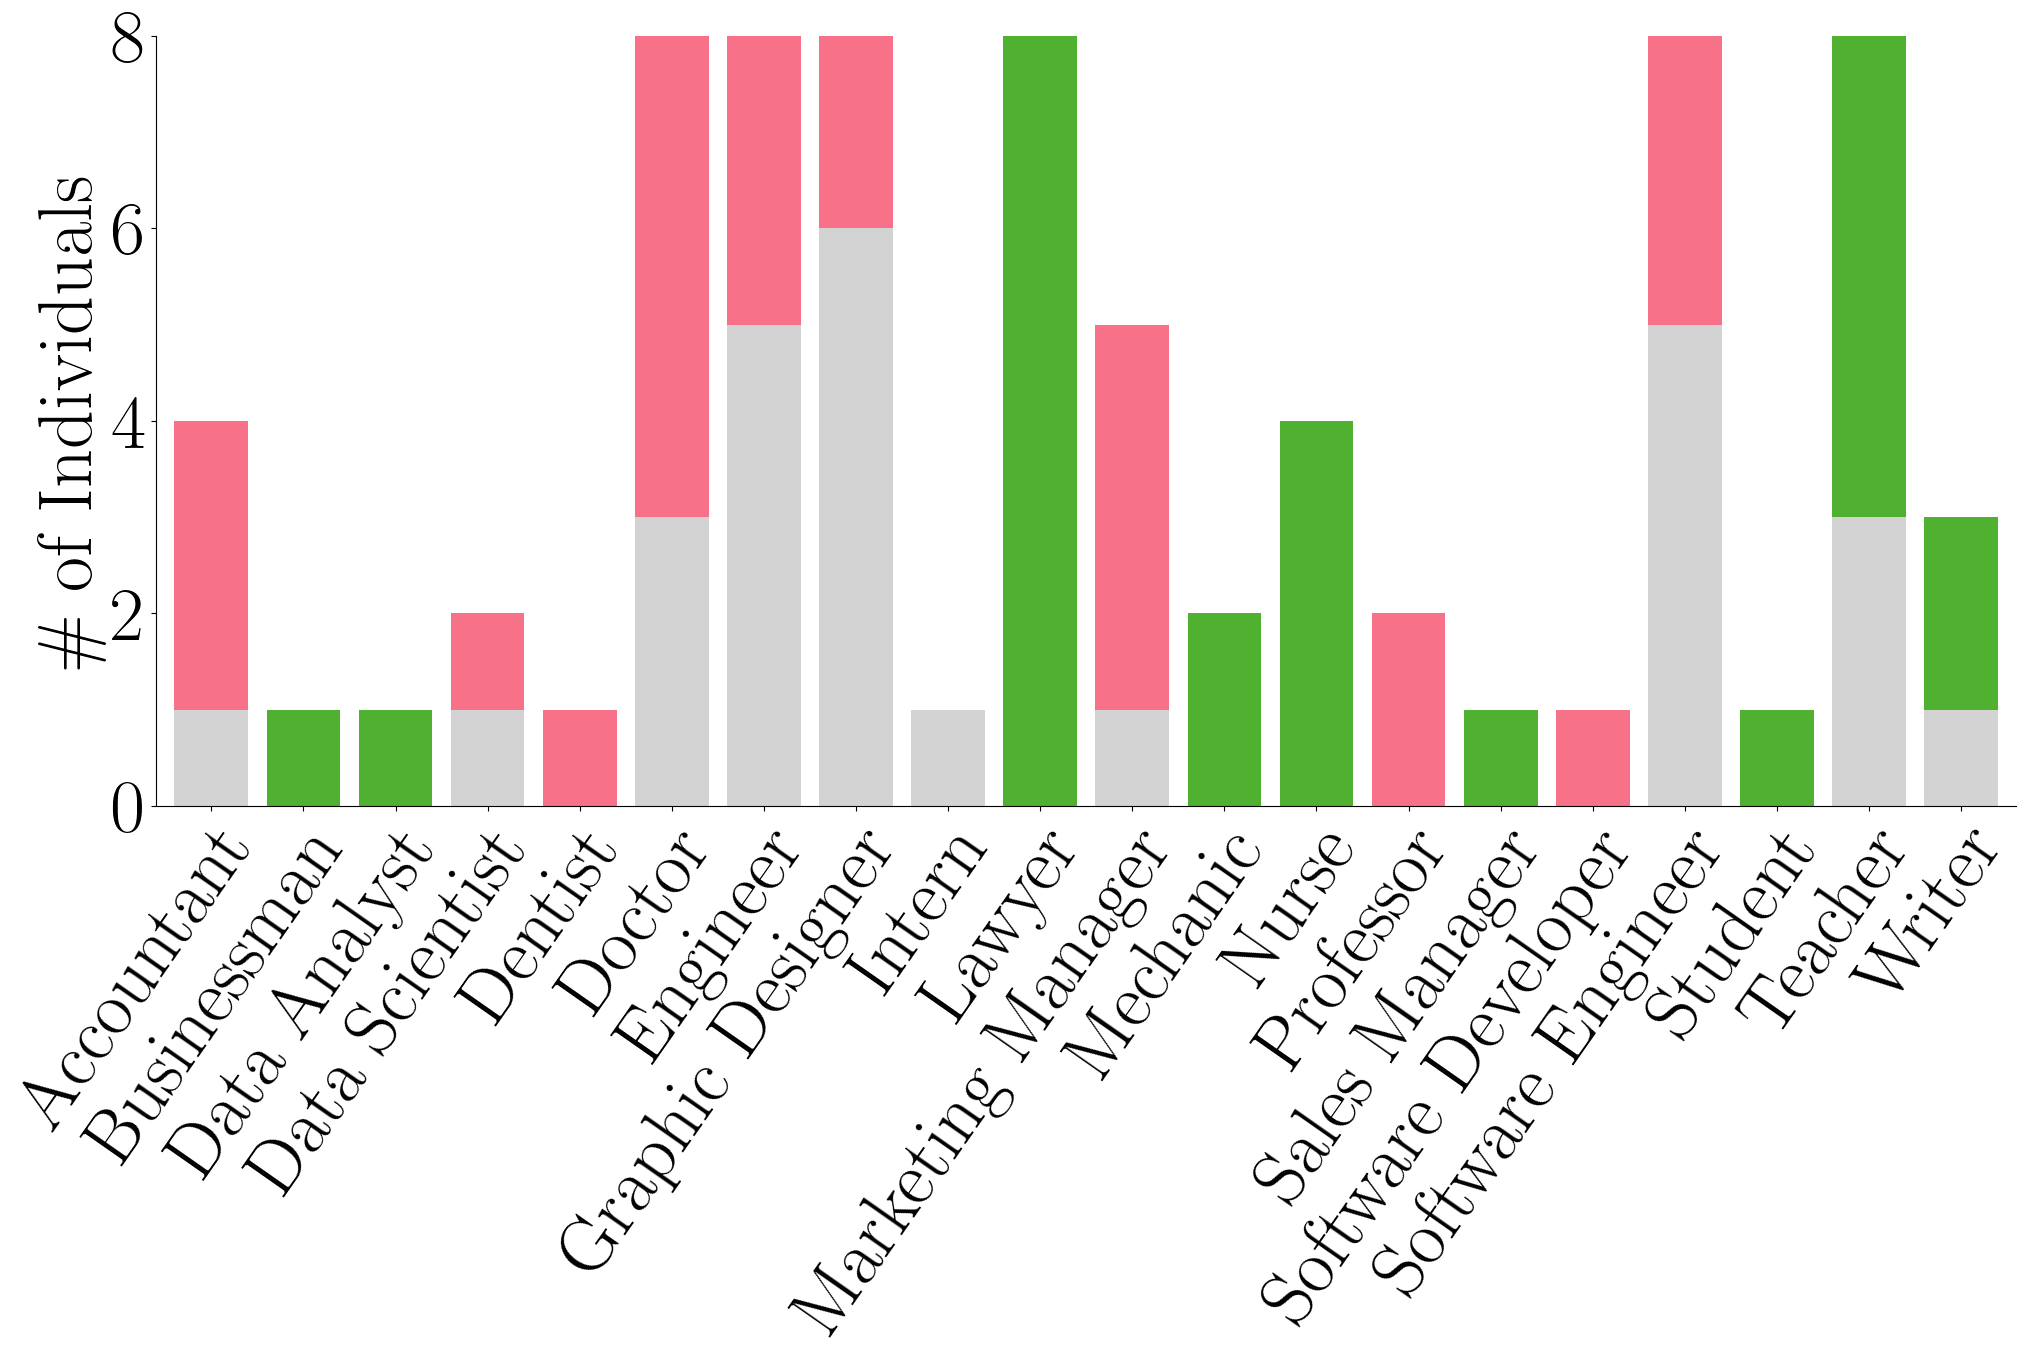

In [27]:
# Figure 4c
occupation_histogram_with_increase_decrease(data, 'Asian American', 'Black or African American')